In [1]:
%reset
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import netCDF4 as nc
import matplotlib.ticker as mticker
import warnings; warnings.filterwarnings('ignore')
import cmocean
from gsw import rho
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import eigs
from scipy.integrate import cumtrapz

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
%cd /net2/smg/documents/OMDT/analysis_CM2p6/grids
os = xr.open_dataset('ocean.static.nc')
fs=xr.open_dataset('ocean_grid.nc')
depth=fs['ht'][:,:]

lon=fs['geolon_t']; lat=fs['geolat_t']
# Coriolis is 2Omega sin(phi) where phi is the latitude of the B-grid velocity point, which should be available in hgrid
Coriolis = 2*7.29e-5*np.sin(fs['geolat_t']/360 *2*np.pi);
#dx = fs['dxt']; dy = fs['dyt']; dxy= (dx**2+dy**2)**0.5
#print(os,fs)

/net2/smg/documents/OMDT/analysis_CM2p6/grids


### For CM2.6 data:

In [3]:
%cd /archive/Richard.Slater/CM2.6/CM2.6_A_Control-1860_V03/history

u = xr.open_dataset('02020101.ocean_minibling_field_u.nc')['u']
v = xr.open_dataset('02020101.ocean_minibling_field_v.nc')['v']
salt = xr.open_dataset('02020101.ocean_minibling_field_salt.nc')['salt']
temp = xr.open_dataset('02020101.ocean_minibling_field_temp.nc')['temp']

z = u.st_ocean
z_edges  = xr.open_dataset('02020101.ocean_minibling_field_u.nc')['st_edges_ocean']
thickness= z_edges.diff('st_edges_ocean').rename({'st_edges_ocean': 'st_ocean'}).assign_coords({"st_ocean":u.st_ocean})

print(thickness)

/arch2/rds/CM2.6/CM2.6_A_Control-1860_V03/history
<xarray.DataArray 'st_edges_ocean' (st_ocean: 50)>
array([ 10.06709957,  10.09290028,  10.12890053,  10.17849922,
        10.24740219,  10.34269714,  10.47480392,  10.6576004 ,
        10.9101944 ,  11.25960541,  11.74169922,  12.40619659,
        13.32000732,  14.57260132,  16.28289795,  18.604599  ,
        21.73239136,  25.90260315,  31.3868103 ,  38.4697876 ,
        47.40710449,  58.35928345,  71.30871582,  85.9883728 ,
       101.85479736, 118.14520264, 134.01159668, 148.69128418,
       161.64074707, 172.59289551, 181.53027344, 188.61315918,
       194.09741211, 198.26745605, 201.39550781, 203.71704102,
       205.42749023, 206.67993164, 207.59399414, 208.25805664,
       208.74047852, 209.08984375, 209.34228516, 209.52539062,
       209.65722656, 209.75244141, 209.82177734, 209.87109375,
       209.90673828, 209.93310547])
Coordinates:
  * st_ocean  (st_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03


In [4]:
%%time 
density_np = rho(salt[-1,:,:,:],temp[-1,:,:,:],0)

CPU times: user 11.9 s, sys: 7.22 s, total: 19.1 s
Wall time: 21.6 s


In [5]:
print(density_np[:,1000,2000])
density = xr.DataArray(density_np,dims   = ['st_ocean','yt_ocean','xt_ocean'],coords={'xt_ocean':temp.xt_ocean,'yt_ocean':temp.yt_ocean,'st_ocean':temp.st_ocean})

<xarray.DataArray 'salt' (st_ocean: 50)>
array([1024.45323503, 1024.47810929, 1024.5091779 , 1024.62303625,
       1024.85239497, 1025.08206604, 1025.15529891, 1025.19495645,
       1025.22121019, 1025.22868762, 1025.24995897, 1025.37412313,
       1025.69071203, 1025.98446189, 1026.08933236, 1026.23423356,
       1026.35170199, 1026.44745724, 1026.52809095, 1026.56945855,
       1026.6329899 , 1026.68828531, 1026.77188566, 1026.85277959,
       1026.94205887, 1027.03798534, 1027.13943469, 1027.2232844 ,
       1027.2952603 , 1027.35710568, 1027.40934106, 1027.4571364 ,
       1027.50108151, 1027.53652345, 1027.56679428, 1027.59223361,
       1027.6107965 , 1027.62334305, 1027.63052167, 1027.63381154,
       1027.63513798, 1027.63573053, 1027.6360304 , 1027.63615241,
       1027.6361961 ,           nan,           nan,           nan,
                 nan,           nan])
Coordinates:
    xt_ocean  float64 -79.95
    yt_ocean  float64 -23.74
  * st_ocean  (st_ocean) float64 5.034 15.1 25

In [6]:
# solves G''(z) + (N^2(z) - omega^2)G(z)/c^2 = 0 G is vertical structure of isopycnal displacement, units m.
#dG/dz = F(z) (here called Gz), vertical structure of horizontal velocity and is unitless

#   subject to G'(0) = gG(0)/c^2 (free surface) & G(-D) = 0 (flat bottom)
# G(z) is normalized so that the vertical integral of (G'(z))^2 is D
# G' is dimensionless, G has dimensions of length

# - N is buoyancy frequency [s^-1] (nX1 vector)
# - depth [m] (maximum depth is considered the sea floor) (nX1 vector)
# - omega is frequency [s^-1] (scalar)
# - mmax is the highest baroclinic mode calculated
# - m=0 is the barotropic mode
# - 0 < m <= mmax are the baroclinic modes
# - Modes are calculated by expressing in finite difference form 1) the
#  governing equation for interior depths (rows 2 through n-1) and 2) the
#  boundary conditions at the surface (1st row) and the bottome (last row).
# - Solution is found by solving the eigenvalue system A*x = lambda*B*x
def vertical_modes(N2_0, Depth, omega, mmax):
    z = -1 * Depth

    if np.size(np.shape(N2_0)) > 1:
        N2 = np.nanmean(N2_0, axis=1)
    else:
        N2 = N2_0

    n = np.size(z)
    nm1 = n - 1
    nm2 = n - 2
    gravity = 9.82
    # ----- vertical increments
    dz = np.concatenate([[0], z[1:] - z[0:nm1]])  # depth increment [m]
    dzm = np.concatenate([[0], 0.5 * (z[2:] - z[0:nm2]), [0]])  # depth increment between midpoints [m]
    # ----- sparse matrices
    # A = row pos, B = col pos, C = val  
    A = np.concatenate([[0], [0], np.arange(1, nm1), np.arange(1, nm1), np.arange(1, nm1), [n - 1]])
    B = np.concatenate([[0], [1], np.arange(1, nm1), np.arange(0, nm2), np.arange(2, n), [n - 1]])
    C = np.concatenate(
        [[-1 / dz[1]], [1 / dz[1]], (1 / dz[2:] + 1 / dz[1:nm1]) / dzm[1:nm1], -1 / (dz[1:nm1] * dzm[1:nm1]),
         -1 / (dz[2:n] * dzm[1:nm1]), [-1]])
        # [[-1 / dz[1]], [1 / dz[1]], (1 / dz[2:] + 1 / dz[1:nm1]) / dzm[1:nm1], -1 / (dz[1:nm1] * dzm[1:nm1]),
        #  -1 / (dz[2:n] * dzm[1:nm1]), [-1]])
    mat1 = coo_matrix((C, (A, B)), shape=(n, n))

    D = np.concatenate([[0], np.arange(1, n)])
    E = np.concatenate([[0], np.arange(1, n)])
    F = np.concatenate([[gravity], N2[1:] - omega * omega])  # originially says N2[1:,10]
    mat2 = coo_matrix((F, (D, E)), shape=(n, n))

    # compute eigenvalues and vectors 
    vals, vecs = eigs(mat1, k=mmax + 1, M=mat2, sigma=0)
    eigenvalue = np.real(vals)
    wmodes = np.real(vecs)
    s_ind = np.argsort(eigenvalue)
    eigenvalue = eigenvalue[s_ind]
    wmodes = wmodes[:, s_ind]
    m = np.size(eigenvalue)
    c = 1 / np.sqrt(eigenvalue)  # kelvin wave speed
    # normalize mode (shapes)
    Gz = np.zeros(np.shape(wmodes))
    G = np.zeros(np.shape(wmodes))
    for i in range(m):
        dw_dz = np.nan * np.ones(np.shape(z))
        dw_dz[0] = (wmodes[1, i] - wmodes[0, i]) / (z[1] - z[0])
        dw_dz[-1] = (wmodes[-1, i] - wmodes[-2, i]) / (z[-1] - z[-2])
        for j in range(1, len(z) - 1):
            dw_dz[j] = (wmodes[j + 1, i] - wmodes[j - 1, i]) / (z[j + 1] - z[j - 1])
        # dw_dz = np.gradient(wmodes[:, i], z)
        norm_constant = np.sqrt(np.trapz((dw_dz * dw_dz), (-1 * z)) / (-1 * z[-1]))
        # norm_constant = np.abs(np.trapz(dw_dz * dw_dz, z) / Depth.max())

        if dw_dz[0] < 0:
            norm_constant = -1 * norm_constant
        Gz[:, i] = dw_dz / norm_constant

        norm_constant_G = np.sqrt(np.trapz((wmodes[:, i] * wmodes[:, i]), (-1 * z)) / (-1 * z[-1]))
        G[:, i] = wmodes[:, i] / norm_constant

    #epsilon = np.nan * np.zeros((5, 5, 5))  # barotropic and first 5 baroclinic
    #for i in range(0, 5):  # i modes
    #    for j in range(0, 5):  # j modes
    #        for m in range(0, 5):  # k modes
    #            epsilon[i, j, m] = np.trapz((Gz[:, i] * Gz[:, j] * Gz[:, m]), -1.0*z) / (-1.0*z[-1])

    return G, Gz, c#, epsilon
#G is the displacement modes and Gz is velocity modes (Gz = dG/dz = F)

In [7]:
drhodz = density.differentiate('st_ocean')
N2 = (9.8*drhodz/1025).coarsen(xt_ocean=5,yt_ocean=5, boundary="exact").mean()

mask = N2*0.0+1.
thickness_full = mask*thickness
positions = thickness_full.cumsum('st_ocean')*mask

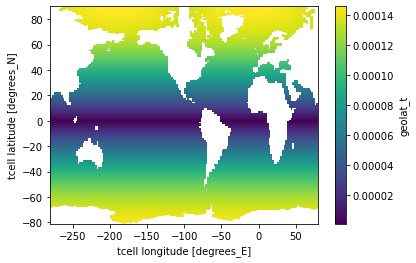

In [8]:
Coriolis_coarse = np.abs(Coriolis.coarsen(xt_ocean=5,yt_ocean=5, boundary="exact").mean())
Coriolis_coarse.plot()

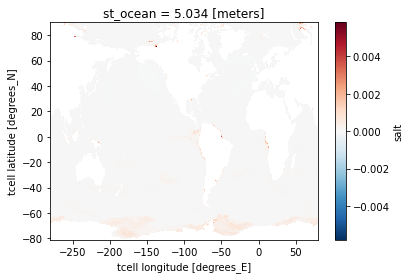

In [9]:
N2[0,:,:].plot()

In [ ]:
%%time
LD_QG = np.empty([540,720])
for i in range(0,720):
    for j in range(0,540):
        N2_ij = np.array(N2[:,j,i])
        N2_filtered= N2_ij[~np.isnan(N2_ij)]
        #print(N2_filtered.shape)
        
        positions_ij = np.array(positions[:,j,i])
        positions_filtered= positions_ij[~np.isnan(N2_ij)]
        #print(positions_filtered.shape)
        
        if N2_filtered.size>=10:
            if np.nanmin(N2_filtered>0):
                nmodes= 7
                [G, Gz, c]=vertical_modes(N2_filtered, positions_filtered, 0, nmodes) #nmodes is number of BC modes, doens't include BT mode
                LD_QG[j,i] = c[1]/np.array(Coriolis_coarse[j,i])
    print(i)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
LD_QG_xr = xr.DataArray(LD_QG,dims   = ['yt_ocean','xt_ocean'],coords={'xt_ocean':Coriolis_coarse.xt_ocean,'yt_ocean':Coriolis_coarse.yt_ocean})


In [ ]:
(LD_QG_xr/1000).plot(vmin=0,vmax=600)
LD_QG=LD_QG_xr

In [170]:
# %cd /work/eay/CM2.6
# ds = xr.Dataset({'LD_QG': (LD_QG)})
# print('done')
# ds.to_netcdf('LD_QG_CM2.6.nc', 'w')
# #%ls

In [ ]:
plt.figure(figsize=(12, 5), dpi= 100, facecolor='w', edgecolor='k')

#plt.plot(LD_QG_xr.yt_ocean,2*np.pi*LD_QG_xr.mean('xt_ocean')/1000,'-',c='r',linewidth=3)
plt.plot(LD_QG['yt_ocean'],LD_QG.mean('xt_ocean')/1000,'-',c='k',linewidth=3)

plt.grid()

#plt.legend(['BT','BC'],loc='upper right',fontsize=11,handlelength=2)
plt.plot([0, 0],[0, 1],'-',color=[0,0,0])
plt.xlim(-80, 80); plt.xticks(fontsize=16);
plt.ylim(0,600); plt.yticks(fontsize=16);
plt.ylabel('$[km]$',fontsize=16)
plt.ylabel('Latitude',fontsize=16)
plt.title('Deformation Radius using flat bottom modes',fontsize=20)

In [168]:
test = xr.open_dataset('LD_QG_CM2.6.nc')
print(test)

<xarray.Dataset>
Dimensions:   (xt_ocean: 720, yt_ocean: 540)
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.7 -279.2 -278.7 ... 78.75 79.25 79.75
  * yt_ocean  (yt_ocean) float64 -81.02 -80.81 -80.6 ... 89.47 89.68 89.89
Data variables:
    LD_QG     (yt_ocean, xt_ocean) float64 ...


Text(0.5, 1.0, 'Deformation Radius using flat bottom modes')

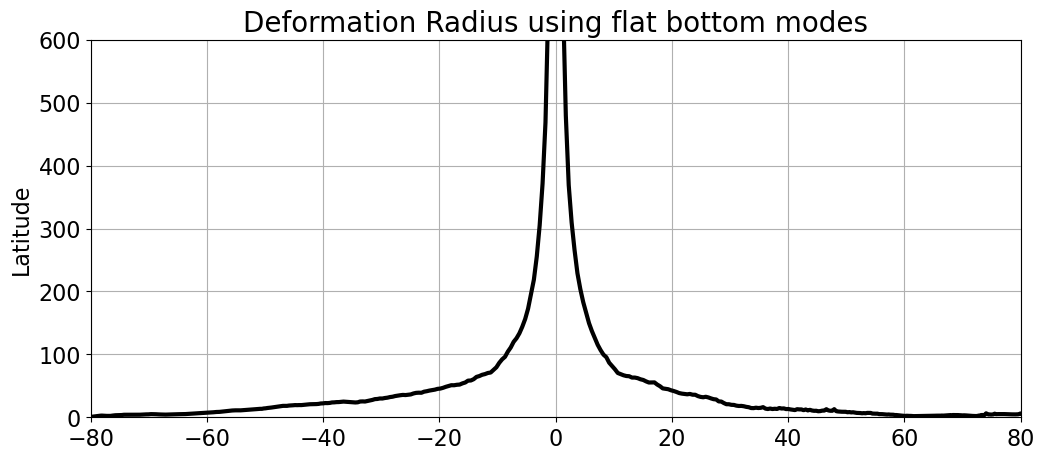

In [169]:
plt.figure(figsize=(12, 5), dpi= 100, facecolor='w', edgecolor='k')

plt.plot(test['yt_ocean'],test['LD_QG'].mean('xt_ocean')/1000,'-',c='k',linewidth=3)

plt.grid()

#plt.legend(['BT','BC'],loc='upper right',fontsize=11,handlelength=2)
plt.plot([0, 0],[0, 1],'-',color=[0,0,0])
plt.xlim(-80, 80); plt.xticks(fontsize=16);
plt.ylim(0,600); plt.yticks(fontsize=16);
plt.ylabel('$[km]$',fontsize=16)
plt.ylabel('Latitude',fontsize=16)
plt.title('Deformation Radius using flat bottom modes',fontsize=20)